# Data Pipeline

1. Load and process CSV files published on https://data.gov.sg/collections/189/view.
2. Load any existing geocoded addresses.
3. Update geocoded addresses.
4. Make H3 geometries.
5. Output data to disk for further downstream analytics.

In [1]:
import sys
sys.dont_write_bytecode = True

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas

import h3
import matplotlib.pyplot as plt
import contextily as cx

# Local imports.
from resale_flat_prices.csv_data.csv_data import CsvData
from resale_flat_prices.geocode.geocoded_addresses import GeocodedAddresses
from resale_flat_prices.h3_utils.h3_statistics import grid_ring_monthly_median_price
from resale_flat_prices.h3_utils.h3_vis_utils import plot_df


# Data directories.
csv_data_dir = Path("../data/ResaleFlatPrices/")
processed_data_dir = Path("../data/processed_data/")

In [2]:
# Load and process raw CSV files published on https://data.gov.sg/collections/189/view.
csv_data = CsvData(csv_data_dir, wanted_columns = "default")
csv_data.load_csv_files()
csv_data.compile_csv_data()
csv_data.process_csv_data()
print("Loaded and compiled CSV data into shape {}.".format(csv_data.df.shape))

Loaded and compiled CSV data into shape (940168, 21).


In [3]:
# Load geocoded addresses.
geocoded_addresses = GeocodedAddresses()
geocoded_addresses.read_json(processed_data_dir / "geocoded_addresses.json")
print("Loaded {} existing geocoded addresses.".format(len(geocoded_addresses.address_dict)))

# Check for new addresses to be geocoded.
all_unique_addresses = set(csv_data.df["address"].unique())
all_unique_geocoded_addresses = geocoded_addresses.get_all_geocoded_addresses()

# Update new geocoded addresses.
missing_addresses = all_unique_addresses.difference(all_unique_geocoded_addresses)
print("Found {} new addresses to be geocoded in loaded CSV data.".format(len(missing_addresses)))
if len(missing_addresses) > 0:
    print("Updating {} new geocoded addresses.".format(len(missing_addresses)))
    geocoded_addresses.update_geocoded_addresses(missing_addresses)
    geocoded_addresses.to_json(processed_data_dir / "geocoded_addresses.json")

# Check for problematic geocodes.
problem_addresses = geocoded_addresses.verify_geocoded_latitudes_and_longitudes(country = "SINGAPORE")
if len(problem_addresses) > 0:
    print("Warning - the following {} addresses do not seem to have been geocoded correctly.".format(
        len(problem_addresses))
    )
    for i, p in enumerate(problem_addresses):
        print("{:05d}: {}.".format(i, p))

Loaded 9867 existing geocoded addresses.
Found 0 new addresses to be geocoded in loaded CSV data.


In [7]:
# H3 cell creation.
RESOLUTION = 9

right_df = geocoded_addresses.make_h3_geometries(resolution = RESOLUTION, crs = "EPSG:4326")
left_df = csv_data.get_df()

df = pd.merge(left = left_df, right = right_df, left_on = "address", right_on = "address", how = "left")
df = geopandas.GeoDataFrame(df, crs = right_df.crs)
unique_cells = df[["h3", "geometry"]].drop_duplicates()

display(df[["year_month", "town", "block", "street_name", "flat_type", "storey_range", "price_per_sqft"]].head())
print(df.shape)

,year_month,town,block,street_name,flat_type,storey_range,price_per_sqft
0,2017-01,ANG MO KIO,406,ANG MO KIO AVE 10,2 ROOM,10 TO 12,489
1,2017-01,ANG MO KIO,108,ANG MO KIO AVE 4,3 ROOM,01 TO 03,346
2,2017-01,ANG MO KIO,602,ANG MO KIO AVE 5,3 ROOM,01 TO 03,363
3,2017-01,ANG MO KIO,465,ANG MO KIO AVE 10,3 ROOM,04 TO 06,362
4,2017-01,ANG MO KIO,601,ANG MO KIO AVE 5,3 ROOM,01 TO 03,367


(940168, 25)


In [5]:
year_months = ["2024-11", "2024-10", "2024-09", "2024-08", "2024-07", "2024-06", "2024-05"]
price_column = "price_per_sqft"

median_prices_df = grid_ring_monthly_median_price(
    df,
    date_column = "year_month", 
    price_column = price_column,
    grid_ring_distance = 1, 
    h3_column_name = "h3",
)
median_prices_df = geopandas.GeoDataFrame(median_prices_df)

median_prices_df_want = median_prices_df[median_prices_df["year_month"].isin(year_months)]
median_prices_df_want = median_prices_df_want.merge(right = unique_cells, left_on = "h3", right_on = "h3", how = "left")
median_prices_df_want = median_prices_df_want.groupby(["year_month", "h3", "geometry"]).aggregate("mean").reset_index()
median_prices_df_want = geopandas.GeoDataFrame(median_prices_df_want, crs = df.crs)

median_prices_df_want.head()

,year_month,h3,geometry,price_per_sqft
0,2024-05,896520c96d3ffff,"POLYGON ((103.77238 1.44814, 103.77053 1.44865...",442.0
1,2024-05,896520ca007ffff,"POLYGON ((103.72285 1.33815, 103.72145 1.33679...",511.5
2,2024-05,896520ca00fffff,"POLYGON ((103.72566 1.34086, 103.7238 1.34137,...",503.5
3,2024-05,896520ca017ffff,"POLYGON ((103.72746 1.3334, 103.72701 1.33526,...",490.0
4,2024-05,896520ca023ffff,"POLYGON ((103.7196 1.3373, 103.71914 1.33917, ...",586.0


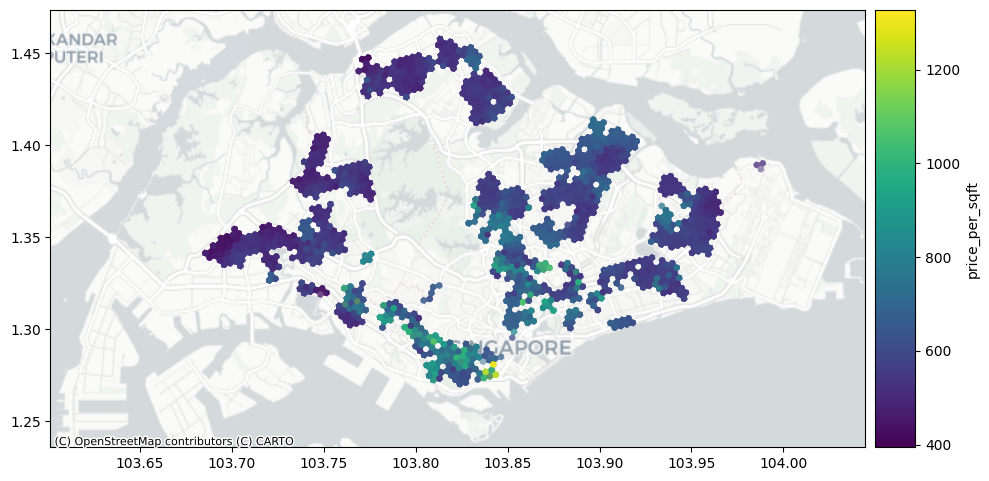

In [6]:
longitude_range = [103.60147592822032, 104.04413678697101]
latitude_range = [1.235860328951441, 1.473569847248408]


plot_df(
    df = median_prices_df_want, 
    plot_kwds = {
        "figsize": [10, 10], 
        "xlim": longitude_range,
        "ylim": latitude_range,
        "column": price_column, 
        "alpha": 0.5,
        "categorical": False,
        "legend": True,
        "legend_kwds": {"label": price_column},
        "edgecolor": None,
        "divider_kwds": {"position": "right", "size": "5%", "pad": 0.1},
    }
)